In [34]:
import warnings

# Imports
import pandas as pd
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
seed = 1234

In [ ]:
dataset = load_dataset("stanfordnlp/imdb")

In [ ]:
df_train = pd.DataFrame(dataset['train'])
#df_train

In [ ]:
# Default parameters
default = {
    "hidden_layer_sizes": np.array([100]),
    "activation": "relu",
    "solver": "adam",
    "alpha": 0.0001,
    "batch_size": "auto",
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_iter": 200,
    "random_state": seed
}

In [35]:
# Functions for building models and plotting error
def build_model(params: dict, X_fulltrain, Y_fulltrain, test_size: int, X_test, Y_test):
    trainX = X_fulltrain[:] # Limit train sizes for faster runtime
    trainY = Y_fulltrain[:]
    # Build classifier
    clf = MLPClassifier(**params)
    clf.fit(trainX, trainY)
    # Predictions
    y_trainpred = clf.predict(X_fulltrain)
    y_testpred = clf.predict(X_test)
    print(f"Classification for training data: {classification_report(Y_fulltrain, y_trainpred)}")
    print(f"Classification for testing data: {classification_report(Y_test, y_testpred)}")
    return {"Train": accuracy_score(Y_fulltrain, y_trainpred), "Test": accuracy_score(Y_test, y_testpred)}
# Plot error
def plot_error(X: list, train: list, test: list, xlabel: str):
    plt.plot(X, train, label="Train", marker=".", color="red")
    plt.plot(X, test, label="Test", marker=".", color="green")
    plt.xlabel = xlabel
    plt.ylabel = "Accuracy"
    plt.legend()
    plt.show()

In [ ]:
# Get Test Dataset
df_test = pd.DataFrame(dataset["test"])
#df_test

# Text Vectorization
When using the IMDB dataset, we discovered that there is only one feature given to us - the text.
Text can have varying length and different features. In addition, text does not have numerical
values, and cannot be graphed as plaintext. As such, we had to find ways to convert them to vectors
of the same size. We came across various methods, including bag-of-words (BOW) approaches such as
CountVectorizer and TF-IDFVectorizer to turn each column into a unique word, and display the score
of each word in the sentence. We also came across Word Embeddings, used to represent words as
low-dimensional vectors.

## Word Embeddings
Due to the high amount of unique words and thus large feature count of the BOW approaches, we opted
to use word embeddings for text vectorization.

In [ ]:
# Turn into w2v_model
vector_size = 100
print("Building model...")
#w2v_model = Word2Vec(sentences=df_train["text"], vector_size = vector_size, window=5, min_count=1)
w2v_model = Word2Vec(sentences = [word_tokenize(line) for line in df_train["text"]], vector_size = vector_size, window = 5, min_count = 1)

def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        sentence_vec = np.zeros(vector_size)
        for word in sentence:
            if word in model.wv:
                sentence_vec += model.wv[word]
        vectors.append(sentence_vec / len(sentence))
    return np.array(vectors)

print("Vectorizing training...")
X_train = vectorize_sentences(df_train["text"], w2v_model, vector_size = vector_size)
Y_train = df_train["label"]
print("Vectorizing testing...")
X_test = vectorize_sentences(df_test["text"], w2v_model, vector_size = vector_size)
Y_test = df_test["label"]

In [ ]:
# First, lets test on size = 10000
train_size = 25000

# Function for testing
def tester(feature_testing: str, feature_list: list, train_size: int, x_values: list):
    train_error = []
    test_error = []
    for feature in feature_list:
        copy_params = deepcopy(default)
        copy_params[feature_testing] = feature
        print(f"Building model {feature_testing}: {feature}")
        err_dict = build_model(copy_params, X_train, Y_train, train_size, X_test, Y_test)
        train_error.append(err_dict["Train"])
        test_error.append(err_dict["Test"])
    plot_error(x_values, train_error, test_error, xlabel=feature_testing)

In [ ]:
# Testing different hidden layer sizes
layer_sizes = [np.array([value]) for value in np.arange(10, 201, 10)] # Note: 100 dimensional vector_size
layers = [val for val in np.arange(10, 201, 10)]
tester('hidden_layer_sizes', layer_sizes, train_size, layers)

In [ ]:
default['hidden_layer_sizes'] = np.array([180])
# Test different activations
activations = ['identity', 'logistic', 'tanh', 'relu']
activation_errors = [1, 2, 3, 4] # Just so it is graphable
tester('activation', activations, train_size, activation_errors)

In [ ]:
# Test different solvers
solvers = ['lbfgs', 'sgd', 'adam']
solver_errors = [1, 2, 3] # Just so it is graphable
tester('solver', solvers, train_size, solver_errors)

In [ ]:
# Test different alpha levels
alphas = np.arange(0.0001, 0.01, 0.0005)
tester('alpha', alphas, train_size, alphas)

In [ ]:
default['alpha'] = 0.0005
# Test different batch sizes
batch_sizes = np.arange(100, 1000, 50)
tester('batch_size', batch_sizes, train_size, batch_sizes)

In [ ]:
default['batch_size'] = 300
# Test different learning rates
learning_rates = ['constant', 'invscaling', 'adaptive']
rate_count = [1, 2, 3]
tester('learning_rate', learning_rates, train_size, rate_count)

In [ ]:
# Test learning rate init size
learning_rate_inits = np.arange(0.001, 0.1, 0.005)
tester('learning_rate_init', learning_rate_inits, train_size, learning_rate_inits)

In [ ]:
# Test max iter
max_iters = np.arange(10, 500, 10)
tester('max_iter', max_iters, train_size, max_iters)

Models did not show better results when increasing/decreasing parameter values. As such, a grid
search is performed to see if the current model's accuracy of 0.65 is possible.

In [ ]:
# Grid search
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
params = {
    "hidden_layer_sizes": [np.array([size]) for size in np.arange(50, 201, 50)],
    "activation": ['logistic', 'tanh', 'relu'],
    "solver": ['sgd'],
    "alpha": np.arange(0.0001, 0.003, 0.001),
    "batch_size": np.arange(200, 301, 50),
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "learning_rate_init": np.arange(0.001, 0.03, 0.01),
    # "max_iter": max_iters # did not improve
}
print("Running Grid Search...")
clf = GridSearchCV(mlp, params)
clf.fit(X_train, Y_train)
print("Finished Grid Search.")

In [ ]:
clf.best_params_

In [ ]:
best_params_one_layer = {
    'activation': 'relu',
    'alpha': 0.001,
    'batch_size': 200,
    'hidden_layer_sizes': np.array([150]),
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.02,
    'solver': 'sgd',
    'random_state': seed
}

In [ ]:
df_results = pd.DataFrame(clf.cv_results_)
df_results.to_csv('./data/feedforwardNN-1_layer.csv', index=False)
df_results

In [ ]:
sorted(df_results, key=df_results["rank_test_score"])

In [ ]:
sorted_df_results = df_results.sort_values(by=["rank_test_score"])
sorted_df_results

In [ ]:
# Test best params vs best found manually
manualClf = MLPClassifier(**default)
manualClf.fit(X_train, Y_train)
yPredManual = manualClf.predict(X_train)
yPredManualTest = manualClf.predict(X_test)
gridClf = MLPClassifier(**best_params_one_layer)
gridClf.fit(X_train, Y_train)
yPredGrid = gridClf.predict(X_train)
yPredGridTest = gridClf.predict(X_test)
print(f"Manual\tTrain:{accuracy_score(Y_train, yPredManual)} Test:{accuracy_score(Y_test, yPredManualTest)}")
print(f"Grid\tTrain:{accuracy_score(Y_train, yPredGrid)} Test: {accuracy_score(Y_test, yPredGridTest)}")

In [ ]:
# Manual performed better than grid search.
best_params_one_layer = default

In [ ]:
# Try adding a second layer?
second_layer_sizes = [np.array([180, layer_size]) for layer_size in np.arange(10, 301, 10)]
sizes = [i for i in np.arange(10, 301, 10)]
tester('hidden_layer_sizes', second_layer_sizes, train_size, sizes)

In [ ]:
# Multi-layer NN performed better
default['hidden_layer_sizes'] = np.array([180, 140])

In [45]:
# Try larger word embeddings?
# Try tokenizing sentences?
from nltk.tokenize import word_tokenize
vector_size = 500
print("Building model...")
w2v_model = Word2Vec(sentences=[word_tokenize(line) for line in df_train["text"]], vector_size = vector_size, window=5, min_count=1)

def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        sentence_vec = np.zeros(vector_size)
        for word in sentence:
            if word in model.wv:
                sentence_vec += model.wv[word]
        vectors.append(sentence_vec / len(sentence))
    return np.array(vectors)

print("Vectorizing training...")
X_train = vectorize_sentences(df_train["text"], w2v_model, vector_size = vector_size)
Y_train = df_train["label"]
print("Vectorizing testing...")
X_test = vectorize_sentences(df_test["text"], w2v_model, vector_size = vector_size)
Y_test = df_test["label"]

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Building model...
Vectorizing training...
Vectorizing testing...


TypeError: 'str' object is not callable

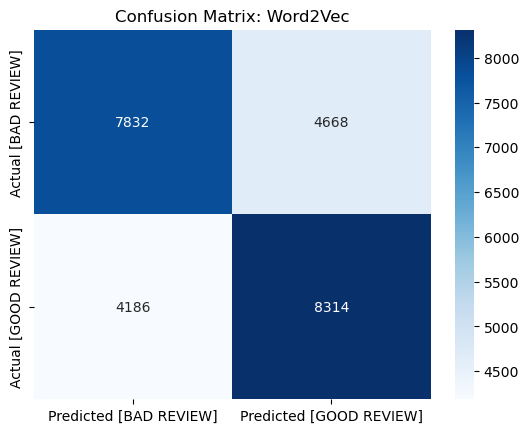

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
clf = MLPClassifier(random_state = seed)
clf.fit(X_train, Y_train)
y_testpred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_testpred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted [BAD REVIEW]', 'Predicted [GOOD REVIEW]'], yticklabels=['Actual [BAD REVIEW]', 'Actual [GOOD REVIEW]'])
plt.title("Confusion Matrix: Word2Vec")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
plt.show()

Building model hidden_layer_sizes: [25]
Classification for training data:               precision    recall  f1-score   support

           0       0.70      0.65      0.68     12500
           1       0.68      0.72      0.70     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000

Classification for testing data:               precision    recall  f1-score   support

           0       0.66      0.63      0.64     12500
           1       0.64      0.67      0.66     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000

Building model hidden_layer_sizes: [50]
Classification for training data:               precision    recall  f1-score   support

           0       0.70      0.71      0.71     12500
           1       0.71      0.70      0.70     12500

 

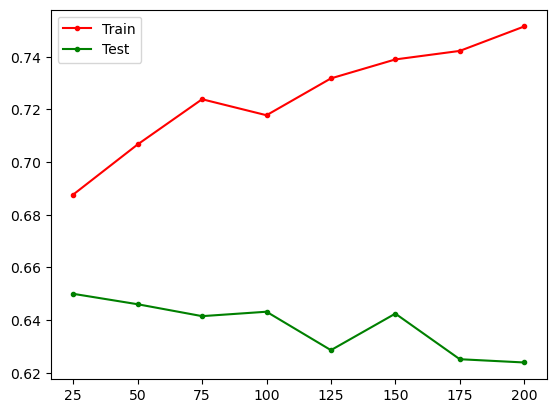

In [36]:
layer_sizes = [np.array([size]) for size in np.arange(25, 201, 25)]
layer_xs = [size for size in np.arange(25, 201, 25)]
tester('hidden_layer_sizes', layer_sizes, train_size=train_size, x_values = layer_xs)

Building model solver: lbfgs
Building model solver: sgd
Building model solver: adam


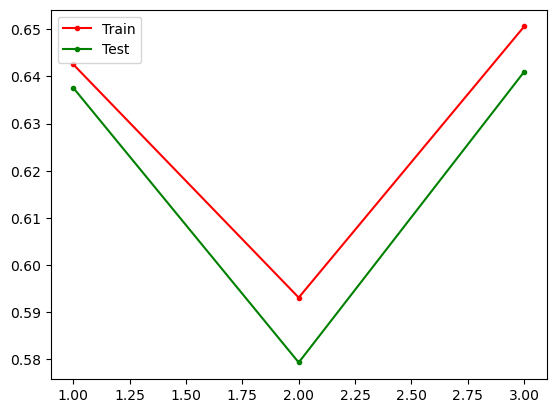

In [25]:
default['hidden_layer_sizes'] = np.array([800])
solvers = ['lbfgs', 'sgd', 'adam']
solver_errors = [1, 2, 3] # Just so it is graphable
tester('solver', solvers, train_size, solver_errors)

Building model alpha: 0.01
Building model alpha: 0.02
Building model alpha: 0.03
Building model alpha: 0.04
Building model alpha: 0.05
Building model alpha: 0.060000000000000005
Building model alpha: 0.06999999999999999
Building model alpha: 0.08
Building model alpha: 0.09
Building model alpha: 0.09999999999999999
Building model alpha: 0.11
Building model alpha: 0.12
Building model alpha: 0.13
Building model alpha: 0.14
Building model alpha: 0.15000000000000002
Building model alpha: 0.16
Building model alpha: 0.17
Building model alpha: 0.18000000000000002
Building model alpha: 0.19
Building model alpha: 0.2


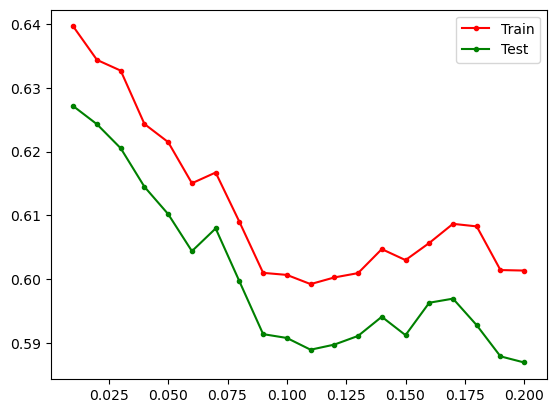

In [26]:
default['solver'] = 'adam'
# alphas = np.arange(0.0001, 0.01, 0.0005)
alphas = np.arange(0.01, 0.21, 0.01)
tester('alpha', alphas, train_size, alphas)

In [50]:
alphas = np.arange(0.0001, 0.01, 0.0005)
tester('alpha', alphas, train_size, alphas)


Building model alpha: 0.0001
Classification for training data:               precision    recall  f1-score   support

           0       0.78      0.80      0.79     12500
           1       0.79      0.78      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

Classification for testing data:               precision    recall  f1-score   support

           0       0.62      0.65      0.64     12500
           1       0.63      0.61      0.62     12500

    accuracy                           0.63     25000
   macro avg       0.63      0.63      0.63     25000
weighted avg       0.63      0.63      0.63     25000

Building model alpha: 0.0006000000000000001
Classification for training data:               precision    recall  f1-score   support

           0       0.76      0.81      0.79     12500
           1       0.80      0.75      0.77     12500

    accu


KeyboardInterrupt



Building model hidden_layer_sizes: [800  50]
Building model hidden_layer_sizes: [800 100]
Building model hidden_layer_sizes: [800 150]
Building model hidden_layer_sizes: [800 200]
Building model hidden_layer_sizes: [800 250]
Building model hidden_layer_sizes: [800 300]
Building model hidden_layer_sizes: [800 350]
Building model hidden_layer_sizes: [800 400]
Building model hidden_layer_sizes: [800 450]
Building model hidden_layer_sizes: [800 500]
Building model hidden_layer_sizes: [800 550]
Building model hidden_layer_sizes: [800 600]
Building model hidden_layer_sizes: [800 650]
Building model hidden_layer_sizes: [800 700]
Building model hidden_layer_sizes: [800 750]
Building model hidden_layer_sizes: [800 800]
Building model hidden_layer_sizes: [800 850]
Building model hidden_layer_sizes: [800 900]
Building model hidden_layer_sizes: [800 950]


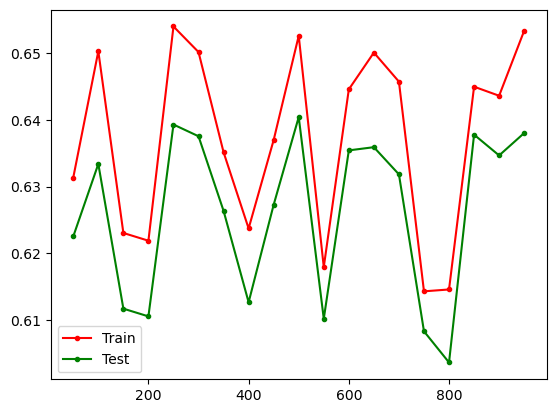

In [28]:
# Multi-layer
layer_sizes = [np.array([800, size]) for size in np.arange(50, 1000, 50)]
layer_xs = [size for size in np.arange(50, 1000, 50)]
tester('hidden_layer_sizes', layer_sizes, train_size=train_size, x_values = layer_xs)

Building model learning_rate_init: 0.001
Building model learning_rate_init: 0.051000000000000004
Building model learning_rate_init: 0.101
Building model learning_rate_init: 0.15100000000000002
Building model learning_rate_init: 0.201
Building model learning_rate_init: 0.251
Building model learning_rate_init: 0.30100000000000005
Building model learning_rate_init: 0.35100000000000003
Building model learning_rate_init: 0.401
Building model learning_rate_init: 0.451
Building model learning_rate_init: 0.501
Building model learning_rate_init: 0.551
Building model learning_rate_init: 0.6010000000000001
Building model learning_rate_init: 0.651
Building model learning_rate_init: 0.7010000000000001
Building model learning_rate_init: 0.751
Building model learning_rate_init: 0.801
Building model learning_rate_init: 0.8510000000000001
Building model learning_rate_init: 0.901
Building model learning_rate_init: 0.9510000000000001


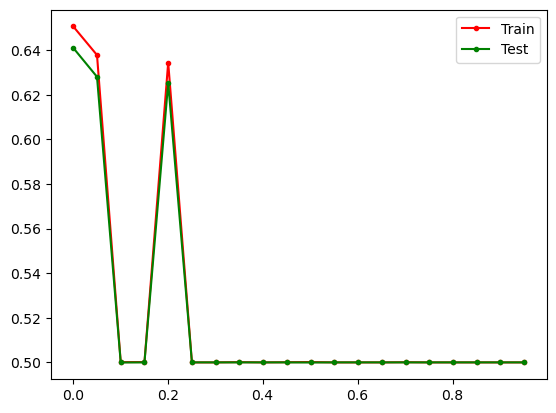

In [30]:
# Test learning rate init size
learning_rate_inits = np.arange(0.001, 1, 0.05)
tester('learning_rate_init', learning_rate_inits, train_size, learning_rate_inits)

In [ ]:
batch_sizes = np.arange(100, 1000, 50)
tester('batch_size', batch_sizes, train_size, batch_sizes)

              precision    recall  f1-score   support

           0       0.62      0.65      0.64     12500
           1       0.63      0.61      0.62     12500

    accuracy                           0.63     25000
   macro avg       0.63      0.63      0.63     25000
weighted avg       0.63      0.63      0.63     25000



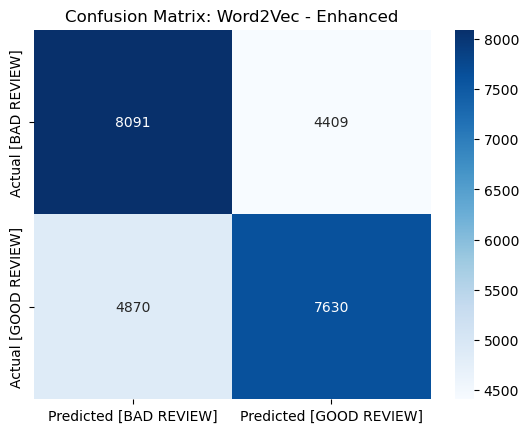

In [51]:
clf = MLPClassifier(**default)
clf.fit(X_train, Y_train)
y_testpred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_testpred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted [BAD REVIEW]', 'Predicted [GOOD REVIEW]'], yticklabels=['Actual [BAD REVIEW]', 'Actual [GOOD REVIEW]'])
plt.title("Confusion Matrix: Word2Vec - Enhanced")
print(classification_report(Y_test, y_testpred))
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
plt.show()

In [ ]:
results = X_test.copy()
results['Actual'] = Y_test
results['Pred'] = ypred
misclassified = results[results['Actual'] != results['Predicted']]
misclassified